In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#export
from lib.nb_02 import *

### Baseline

In [4]:
x_train, y_train, x_valid, y_valid = get_mnist()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs=64, num_workers=6)
data = Databunch(train_dl, valid_dl, c_in=784, c_out=10)

In [5]:
def get_model(data, lr=0.1):
    model = nn.Sequential(nn.Linear(data.c_in,200), nn.ReLU(), nn.Linear(200, data.c_out))
    return model, optim.SGD

In [6]:
model, opt_func = get_model(data)

In [7]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback]

In [8]:
learn = Learner(model,data, F.cross_entropy, opt_func, cb_funcs=cbfs)

In [9]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.369676,0.709860,0.656912,0.864600,00:01


This is our SGD baseline.

Writing our own coustom Optimizer

### Optimizer

In [10]:
#export
def compose(x, funcs, *args, order_key="_order", **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

In [11]:
class Optimizer():
    
    def __init__(self, params, steppers, **defaults):
        
        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
            
        self.hypers = [{**defaults} for k in self.param_groups]
        self.steppers = steppers
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [12]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [13]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [14]:
model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=opt_func, cb_funcs=cbfs)

In [15]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.359712,0.717880,0.649040,0.861700,00:01


#### scheduler and recorder

In [16]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [17]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [18]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [19]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

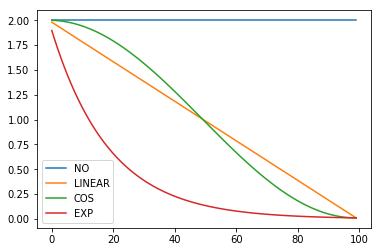

In [20]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [21]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [22]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

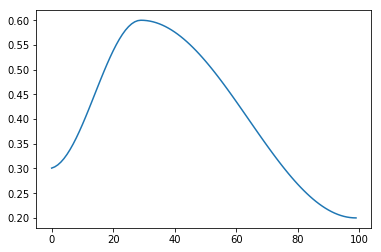

In [23]:
plt.plot(a, [sched(o) for o in p])

In [24]:
cbfs = [partial(AvgStatsCallback,accuracy), Recorder, ProgressCallback]
model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=opt_func, cb_funcs=cbfs)

In [25]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.361250,0.718080,0.654502,0.862600,00:02
1,0.551989,0.866020,0.422625,0.893000,00:02


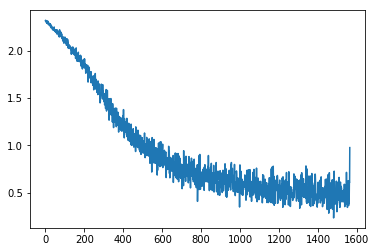

In [26]:
learn.recorder.plot_loss()

In [27]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder, ProgressCallback, 
        partial(ParamScheduler, 'lr', sched)]
model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=opt_func, cb_funcs=cbfs)

In [28]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.320681,0.904000,0.176432,0.948000,00:02
1,0.107531,0.968040,0.093491,0.973200,00:02


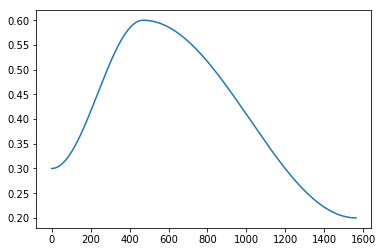

In [29]:
learn.recorder.plot_lr()

### Weight Decay

In [30]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [31]:
#export
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

In [32]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [33]:
#export 
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [34]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder, ProgressCallback, 
        partial(ParamScheduler, 'lr', sched)]
model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=sgd_opt, cb_funcs=cbfs)

In [35]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.317467,0.905640,0.130678,0.961600,00:02
1,0.104736,0.968560,0.104555,0.968500,00:02


### Momentum

Momentum requires to add some state. We need to save the moving average of the gradients to be able to do the step and store this inside the optimizer state. To do this, we introduce statistics. Statistics are object with two methods:
- `init_state`, that returns the initial state (a tensor of 0. for the moving average of gradients)
- `update`, that updates the state with the new gradient value

We also read the `_defaults` values of those objects, to allow them to provide default values to hyper-parameters.

In [36]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [37]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError    

In [38]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [39]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [40]:
#export
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                  stats=AverageGrad(), wd=0.01)

In [41]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder, ProgressCallback, 
        partial(ParamScheduler, 'lr', sched)]
model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=sgd_mom_opt, cb_funcs=cbfs)

In [42]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.743853,0.794160,0.858210,0.755100,00:02
1,0.624344,0.829900,0.413391,0.883400,00:03


*Momentum Experiments*

In [43]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [44]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

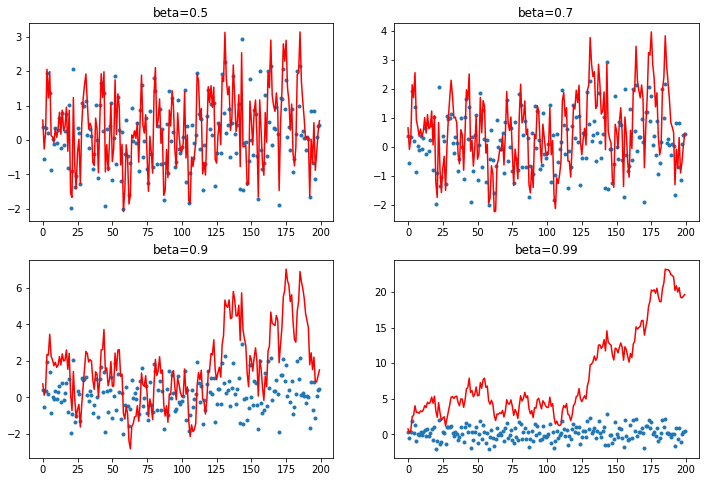

In [45]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi
    return res,res
plot_mom(mom1)

In [46]:
#export
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

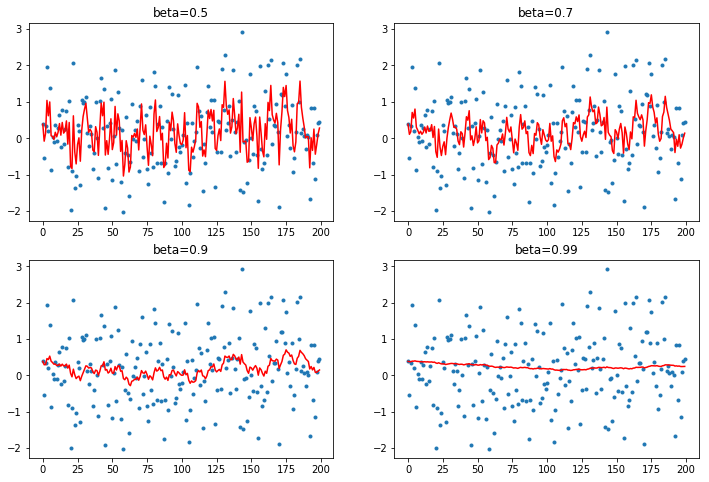

In [47]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = lin_comb(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

In [48]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [49]:
y[0]=0.5

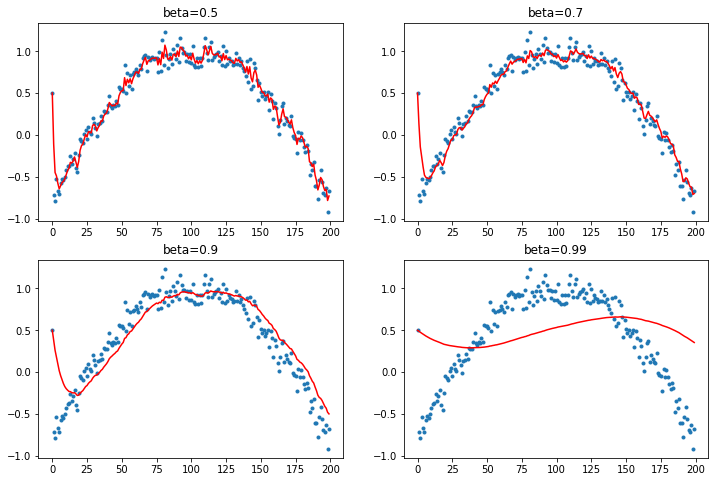

In [50]:
plot_mom(mom2)

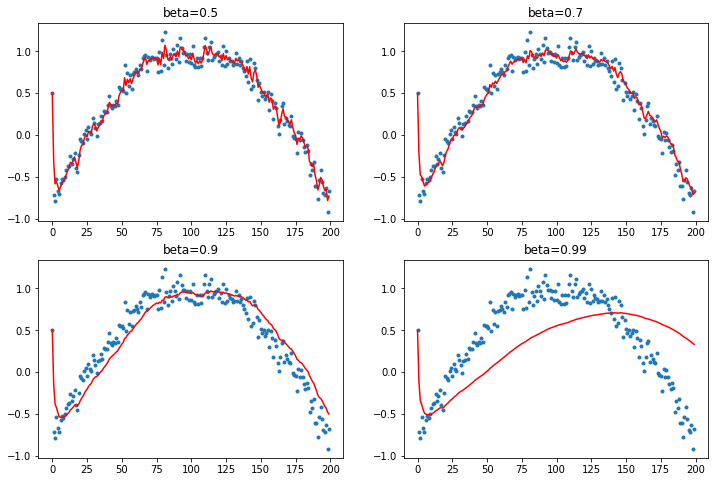

In [51]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

### Adam - `Not Working`

In [52]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

In [53]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [54]:
#export
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [55]:
#export
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [56]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [57]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[weight_decay,adam_step]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [58]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder, ProgressCallback, 
        partial(ParamScheduler, 'lr', sched)]
model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=sgd_opt, cb_funcs=cbfs)

In [59]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.325970,0.903420,0.141168,0.957400,00:03
1,0.116390,0.964460,0.105971,0.969700,00:02
2,0.063836,0.981520,0.080711,0.976300,00:03


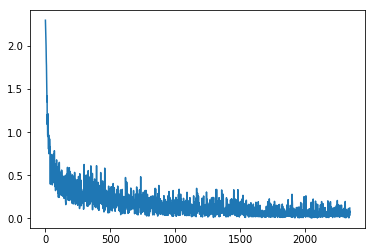

In [60]:
learn.recorder.plot_loss()

In [61]:
#export
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [62]:
#export
lamb = partial(StatefulOptimizer, 
               steppers=lamb_step, 
               stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [63]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder, ProgressCallback, 
        partial(ParamScheduler, 'lr', sched)]
model, _ = get_model(data)
learn = Learner(model,data, F.cross_entropy, opt_func=lamb, cb_funcs=cbfs)      

In [64]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.780855,0.124120,2.440662,0.096700,00:04
1,2.489266,0.100700,2.463997,0.096200,00:05


In [65]:
!python notebook2script.py 03_optimizers.ipynb

Converted 03_optimizers.ipynb to lib/nb_03.py
